# Data augmentation

Based on https://arxiv.org/pdf/1710.01927.pdf

In [109]:
from data_loader import load_data
import numpy as np
import matplotlib.pyplot as plt
import random
from statistics import mean

In [84]:
X, Y, groups, coord = load_data()

In [85]:
l= np.where(groups == 24)
l

(array([531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541], dtype=int64),)

## CTRL augmentation

In [86]:
X[531]

array([0.25872  , 0.307231 , 0.336937 , ..., 0.0080371, 0.0114503,
       0.0143185])

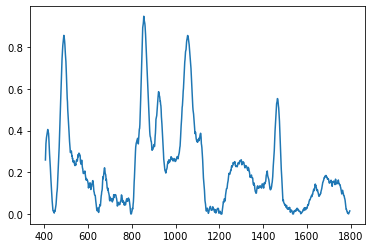

In [87]:
plt.plot(coord[531], X[531])

## Offset : 0,1 x Standard deviation of dataset

In [88]:
full=[]
for i in X:
    for j in i:
        full.append(j)

In [111]:
stdf = np.std(full)
meanf= mean(full)

In [90]:
X_offset=[]
for i in X[531]:
    X_offset.append(i+(0.1*stdf))

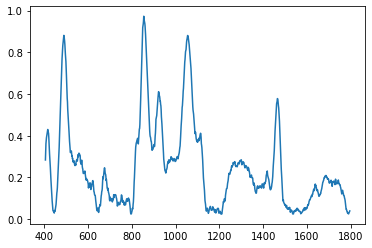

In [91]:
plt.plot(coord[531], X_offset)

## Multiplication : 1+- 0,1 x std

In [92]:
X_multiplication=[]
for i in X[531]:
    X_multiplication.append(i*(1.1*stdf))

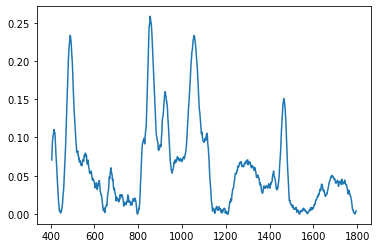

In [93]:
plt.plot(coord[531], X_multiplication)

In [94]:
X_slope=[]
for i in X[531]:
    X_slope.append(random.uniform(0.95, 1.05) * stdf * i)

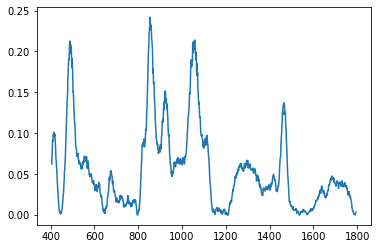

In [95]:
plt.plot(coord[531], X_slope)

## Gaussian noise

In [116]:
noise = np.random.normal(meanf,stdf,len(X[531]))
noise

array([ 0.12860246,  0.22993245, -0.0092645 , ...,  0.07962116,
        0.17676206,  0.60293189])

In [119]:
X_gaussian = []
for i in range(len(X[531])):
    res = X[531][i]+noise[i]
    if res > 0:
        X_gaussian.append(res)
    else:
        X_gaussian.append(0)

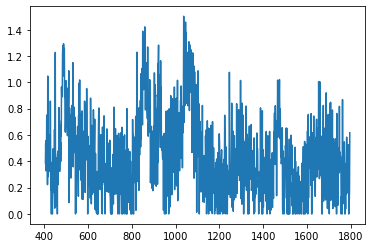

In [120]:
plt.plot(coord[531], X_gaussian)

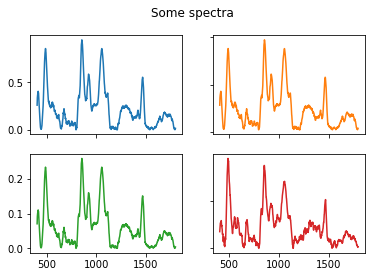

In [57]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Some spectra')
ax1.plot(coord[531], X[531])
ax2.plot(coord[532], X_offset, 'tab:orange')
ax3.plot(coord[533], X_multiplication, 'tab:green')
ax4.plot(coord[534], X[534], 'tab:red')


for ax in fig.get_axes():
    ax.label_outer()